# The Battle of Neighborhoods - Madrid Assessment

## Introduction

### Overview

This project is aimed at analyzing the best areas to buy a house in Madrid. The analysis will be based on the number of restaurants, schools, shops or metro lines available in the different neighborhood as well as on the potential renting profit on the area. Where the annual renting profit is computed as the renting price per month multiplied by the months in a year and divided by the sale price. 
This problem could be of interest for anyone who is considering buying a house in a big city, either for living or investing.

### Configuration

We start the notebook by importing the necessary libraries and setting the foursquare credentials

In [50]:
# Import necessary library
import json
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests
import numpy as np
import foursquare
import folium
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import unidecode to remove accents
import unidecode

In [51]:
CLIENT_ID = 'TO BE COMPLETED' # your Foursquare ID
CLIENT_SECRET = 'TO BE COMPLETED' # your Foursquare Secret
CLIENT_ID_2 = 'TO BE COMPLETED'
CLIENT_SECRET_2 = 'TO BE COMPLETED'
VERSION = '20180605' # Foursquare API version

In order to find the best neighborhoods in Madrid to buy a house, we are going to use foursquare to look for the list of hospitals, schools, parks, restaurants, metro and bus stations, etc. within 5 minutes-walk (500 meters distance) in each neighborhood.

The categories that are going to be processed in foursquare as well as the radius and limit parameters are defined below:

In [54]:
fs_categories = {
    'Food': '4d4b7105d754a06374d81259',
    'Food & Drink Shop': '4bf58dd8d48988d1f9941735',
    'Clothing Store':'4bf58dd8d48988d103951735',
    'Bus Stop': '52f2ab2ebcbc57f1066b8b4f',
    'Metro Station': '4bf58dd8d48988d1fd931735',
    'Arts & Entertainment': '4d4b7104d754a06370d81259',
    'Park':'4bf58dd8d48988d163941735',
    'Athletics & Sports':'4f4528bc4b90abdf24c9de85',
    'Hospital':'4bf58dd8d48988d196941735',
    'School':'4bf58dd8d48988d13b941735',
    'University':'4bf58dd8d48988d1ae941735',
    'Bank':'4bf58dd8d48988d10a951735',
    'Pharmacy':'4bf58dd8d48988d10f951735'
}

', '.join([ cat for cat in fs_categories])

RADIUS = 500 # 500m, around 5 minutes walking time
LIMIT = 100

### Functions

This section includes the definition of the functions to be used along the notebook

__Venues_nearby__ - this function is aimed at looking for the venues within a given category in foursquare

In [55]:
# Define a function to search nearby information and convert the result as dataframe
def venues_nearby(latitude, longitude, category, verbose=True):    

    # create URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        RADIUS, 
        LIMIT,
        fs_categories[category])
    
    results = requests.get(url).json()
    cols = ['Name','Latitude','Longitude','Address']    

    try:
        df = json_normalize(results['response']['venues'])
        if( len(df) == 0 ):                    
            df = pd.DataFrame(columns=cols)
        else: 
            try:                
                df = df[['name','location.lat','location.lng','location.address']]
            except:
                df = df[['name','location.lat','location.lng','location.formattedAddress']]
        df.columns = cols
    except:
        df = pd.DataFrame(columns=cols)
    return df

__get_category_type__ - function that extracts the category of the venue

In [56]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

__remove_accents__ - Function to remove accents (required to compare mad.json data and sale/rent prices data)

In [57]:
# Function to remove accents (required to compare mad.json data and sale/rent prices data)
def remove_accents(a):
    return unidecode.unidecode(a)

__coordinates_dataframe__ - Function to get the centroid coordinates of each Neighborhood by processing the dataframe generated from the json

In [58]:
def coordinates_dataframe(input_df):
    cols=['Neighborhood','latitude','longitude']
    df_coord = pd.DataFrame(columns=cols)
    df_coord['Neighborhood']=input_df['properties.name']
    idx=0
    for idx in range(0,len(df_mad['properties.name'])):
        coordArray=np.asarray(input_df.iloc[idx]['geometry.coordinates'][0][0])
        df_coord.iloc[idx]['latitude']=coordArray[:,1].mean()
        df_coord.iloc[idx]['longitude']=coordArray[:,0].mean()
    return df_coord

## Data Processing

The list of neighboorhoods in Madrid and their coordinates are obtained from the madrid.geojson obtained from https://github.com/codeforamerica/click_that_hood/blob/master/public/data/madrid.geojson

Note that the reference position of each neighborhood (used then to look for the different venues in each area) is computed as the centroid of the coordinates defining each polygon

In [59]:
with open('madrid.geojson', 'r', encoding='utf-8') as f:
    madrid_json = json.load(f)

# Store the data in a dataframe
df_mad = json_normalize(madrid_json['features'])

# Process the dataframe to get the latitude and Longitude position of each neighborhood
mad_neigh=coordinates_dataframe(df_mad)

The mad_neigh dataframe looks as follows:

In [60]:
mad_neigh.tail()

,Neighborhood,latitude,longitude
123,Alameda de Osuna,40.4566,-3.59166
124,Aeropuerto,40.4769,-3.55006
125,Casco Histórico de Barajas,40.4755,-3.57775
126,Timón,40.4895,-3.59815
127,Corralejos,40.4676,-3.60347


The number of Neighborhoods in Madrid is 128

In [61]:
mad_neigh.shape

(128, 3)

We use foursquare to look for the list of hospitals, schools, parks, restaurants, metro and bus stations, etc. within 5 minutes-walk (500 meters distance) from the reference position (refer to the "configuration" section for the list of categories considered for this analysis).

We loop for each neighborhood and within each neighborhood we loop for each category to obtain the list of venues of each type in each area.

Given that there is a limitation on the maximum number of calls to foursquare, we divide the neighborhoods dataframe in two  different blocks and we use two different foursquare accounts for each of them

In [11]:
# construct a dataframe to store data
df_venues = pd.DataFrame(columns=['Neighborhood','Category', 'Name', 'Latitude', 'Longitude', 'Address'])

# Due to foursquare limitations, we divide mad_neigh in two dataframes and we use two different foursquare accounts
mad_neigh_first=mad_neigh.iloc[0:int(len(mad_neigh)/2)]
mad_neigh_second=mad_neigh.iloc[int(len(mad_neigh)/2):-1]
numNeigh=0

for neighborhood, latitude, longitude in zip(mad_neigh_first['Neighborhood'], mad_neigh_first['latitude'], mad_neigh_first['longitude']):
    numNeigh=numNeigh+1
    print('{} - Neighborhood: {}, Latitude: {}, Longitude: {}'.format(numNeigh,neighborhood,latitude,longitude))
    for cat, cat_id in fs_categories.items():
        df = venues_nearby(latitude, longitude, cat, verbose=False)
        df['Category'] = cat
        df['Neighborhood'] = neighborhood
        df_venues = df_venues.append(df, sort=True)

CLIENT_ID = CLIENT_ID_2
CLIENT_SECRET = CLIENT_SECRET_2
for neighborhood, latitude, longitude in zip(mad_neigh_second['Neighborhood'], mad_neigh_second['latitude'], mad_neigh_second['longitude']):
    numNeigh=numNeigh+1
    for cat, cat_id in fs_categories.items():
        df = venues_nearby(latitude, longitude, cat, verbose=False)
        df['Category'] = cat
        df['Neighborhood'] = neighborhood
        df_venues = df_venues.append(df, sort=True)

1 - Neighborhood: Palacio, Latitude: 40.41769423529412, Longitude: -3.711137682352941


KeyboardInterrupt: 

Save the venues obtained with foursquare in a csv file

In [62]:
#df_venues.to_csv('df_venues.csv')
df_venues=pd.read_csv('df_venues.csv')

In [63]:
df_venues.head(20)

,Unnamed: 0,Address,Category,Latitude,Longitude,Name,Neighborhood
0,0,"Pl. Oriente, 2",Food,40.418081,-3.711867,Café de Oriente,Palacio
1,1,Plaza De Oriente 6,Food,40.418598,-3.711352,La Lonja del Mar,Palacio
2,2,27 C. de Preciados,Food,40.419668,-3.706135,Starbucks Preciados 27,Palacio
3,3,"C. Pasadizo de San Ginés, 5",Food,40.416754,-3.707079,Chocolatería San Ginés,Palacio
4,4,Calle Mayor,Food,40.416095,-3.708119,Torrons Vicens: Artesa D' Agramunt,Palacio
5,5,"C. Mayor, 7",Food,40.416343,-3.705682,Museo del Jamón,Palacio
6,6,NaN,Food,40.415045,-3.708306,Mesón De San Miguel,Palacio
7,7,"C. Mayor, 2",Food,40.416651,-3.704662,La Mallorquina,Palacio
8,8,Plaza Mayor,Food,40.415446,-3.707157,Una Copa de Balon,Palacio
9,9,Mercado de San Miguel,Food,40.415313,-3.711930,Horno La Santiaguesa,Palacio


We use the pivot_table method of pandas dataframe to generate a new table with the number of venues of each type in all the neighborhoods.
This table will be then used to classify the areas depending on the number of facilities of each type available

In [64]:
df_pivot=df_venues.pivot_table(index='Neighborhood', columns='Category', values='Name', aggfunc='count')
df_pivot.head()

Category,Arts & Entertainment,Athletics & Sports,Bank,Bus Stop,Clothing Store,Food,Food & Drink Shop,Hospital,Metro Station,Park,Pharmacy,School,University
Neighborhood,,,,,,,,,,,,,
Abrantes,6.0,6.0,6.0,NaN,NaN,35.0,12.0,1.0,2.0,3.0,2.0,1.0,NaN
Acacias,48.0,40.0,34.0,1.0,7.0,50.0,36.0,NaN,3.0,9.0,17.0,13.0,1.0
Adelfas,26.0,13.0,16.0,6.0,12.0,50.0,42.0,NaN,4.0,5.0,12.0,7.0,NaN
Alameda de Osuna,4.0,8.0,10.0,NaN,1.0,31.0,6.0,NaN,2.0,5.0,4.0,7.0,NaN
Almagro,48.0,22.0,50.0,2.0,42.0,50.0,39.0,4.0,7.0,NaN,20.0,18.0,6.0


We reorder the table and rename the food column as "restaurants"

In [65]:
df_pivot = df_pivot[['Metro Station','Bus Stop','School', 'University',
        'Hospital', 'Pharmacy','Bank', 'Food',
        'Clothing Store', 'Food & Drink Shop', 
        'Park','Arts & Entertainment', 'Athletics & Sports']]
df_pivot.rename(columns={'Food': 'Restaurants'}, inplace=True)
df_pivot.head()

Category,Metro Station,Bus Stop,School,University,Hospital,Pharmacy,Bank,Restaurants,Clothing Store,Food & Drink Shop,Park,Arts & Entertainment,Athletics & Sports
Neighborhood,,,,,,,,,,,,,
Abrantes,2.0,NaN,1.0,NaN,1.0,2.0,6.0,35.0,NaN,12.0,3.0,6.0,6.0
Acacias,3.0,1.0,13.0,1.0,NaN,17.0,34.0,50.0,7.0,36.0,9.0,48.0,40.0
Adelfas,4.0,6.0,7.0,NaN,NaN,12.0,16.0,50.0,12.0,42.0,5.0,26.0,13.0
Alameda de Osuna,2.0,NaN,7.0,NaN,NaN,4.0,10.0,31.0,1.0,6.0,5.0,4.0,8.0
Almagro,7.0,2.0,18.0,6.0,4.0,20.0,50.0,50.0,42.0,39.0,NaN,48.0,22.0


Processing the pivot table, it is noted that there are some neighborhoods not included in the table. This is because for these areas, no venues are returned by the foursquare call. As shown below, there 121 areas out of 128

In [66]:
df_pivot.shape

(121, 13)

In order to have the full list of neighborhoods in the pivot table, we merge it with the "mad_neigh" dataframe with the complete list of neighborhoods in Madrid

In [67]:
df_pivot=pd.merge(mad_neigh['Neighborhood'], df_pivot, on='Neighborhood', how='left')
df_pivot.shape


(128, 14)

As shown above, there are some NAN values for those categories with no venue in the corresponding area. 
Therefore, we replace the NANs by zeros

In [68]:
df_pivot.fillna(0, inplace=True)
df_pivot.head()

,Neighborhood,Metro Station,Bus Stop,School,University,Hospital,Pharmacy,Bank,Restaurants,Clothing Store,Food & Drink Shop,Park,Arts & Entertainment,Athletics & Sports
0,Palacio,3.0,3.0,9.0,3.0,0.0,22.0,23.0,50.0,48.0,48.0,7.0,50.0,18.0
1,Embajadores,5.0,2.0,12.0,1.0,0.0,20.0,26.0,50.0,46.0,48.0,3.0,50.0,26.0
2,Cortes,6.0,8.0,9.0,1.0,0.0,20.0,49.0,50.0,50.0,48.0,1.0,50.0,34.0
3,Justicia,9.0,3.0,11.0,7.0,0.0,30.0,47.0,50.0,50.0,48.0,7.0,50.0,45.0
4,Universidad,8.0,5.0,21.0,7.0,1.0,43.0,45.0,50.0,50.0,47.0,6.0,50.0,49.0


## Results

### Cluster Neighborhoods Analysis

Using Kmeans, we classify the neighborhoods in five different groups depending on the type and number of facilities available in each neighborhood

In [69]:
# set number of clusters
kclusters = 5

madrid_grouped_clustering = df_pivot.iloc[:,3:-1]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)


We add a new column in the dataframe with the cluster label

In [70]:
# add clustering labels
madrid_grouped_clustering=df_pivot
madrid_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

Now we filter the dataframe by the cluster label, and we compute the mean number of facilities among the neighborhoods in the cluster. For instance, see below the meann number of facilities for cluster 0

In [71]:
madrid_grouped_clustering[madrid_grouped_clustering['Cluster Labels']==0].mean(axis=0).round()

Cluster Labels           0.0
Metro Station            3.0
Bus Stop                 4.0
School                   9.0
University               1.0
Hospital                 1.0
Pharmacy                12.0
Bank                    24.0
Restaurants             50.0
Clothing Store          20.0
Food & Drink Shop       36.0
Park                     5.0
Arts & Entertainment    32.0
Athletics & Sports      17.0
dtype: float64

We repeat the same process for all the clusters and we generate a barh figure with the mean results obtained for each of them

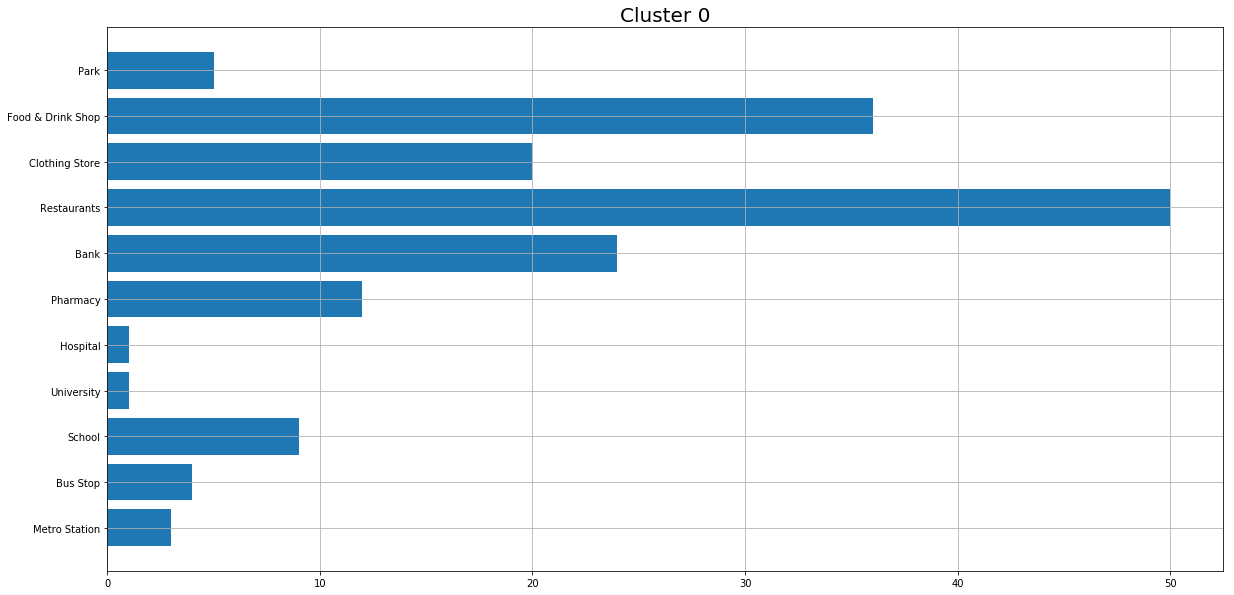

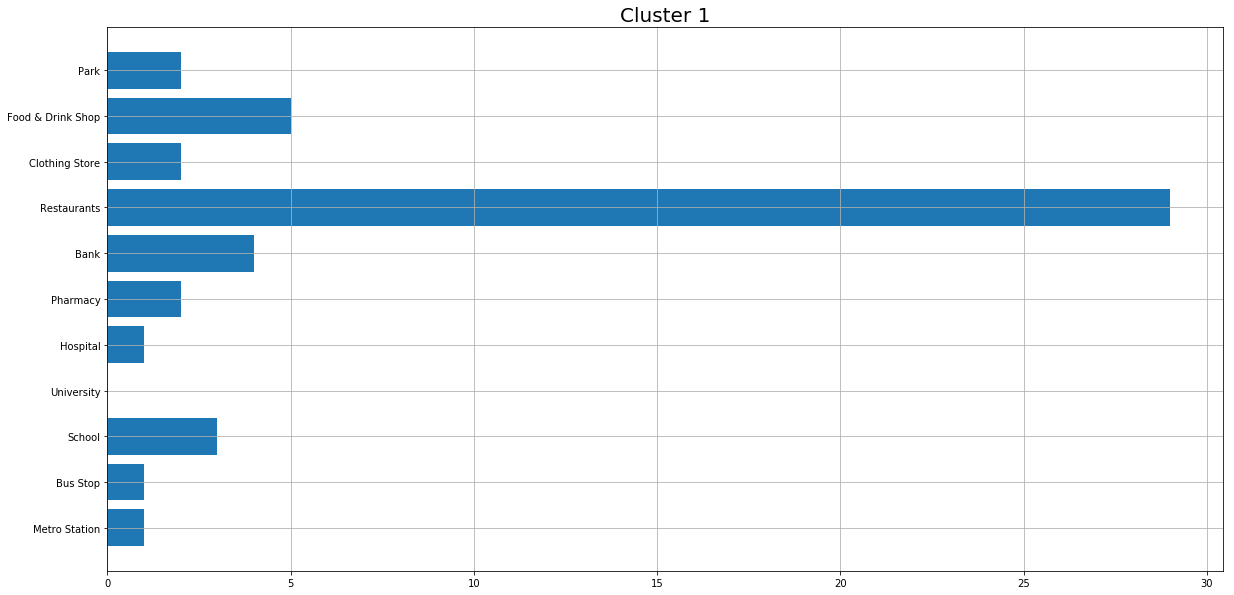

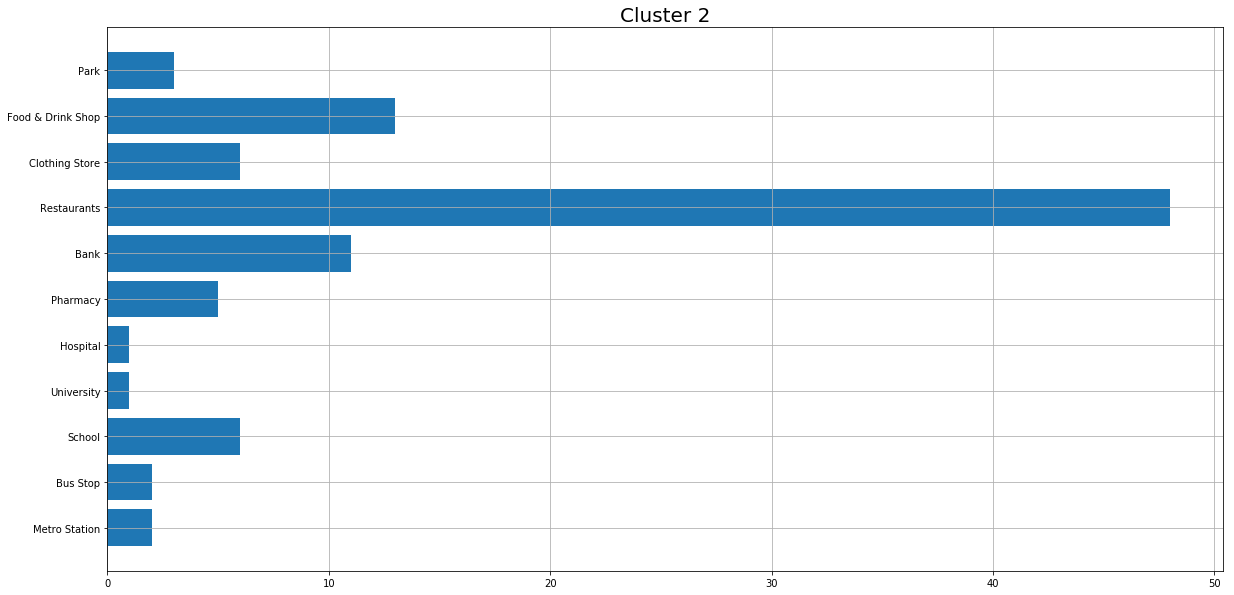

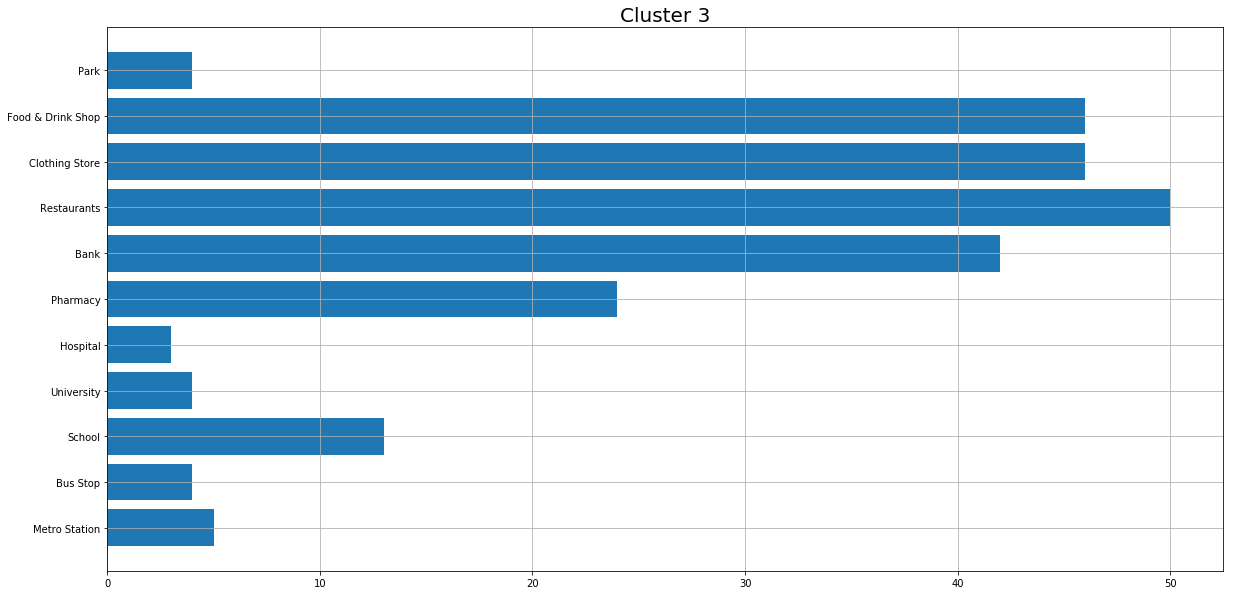

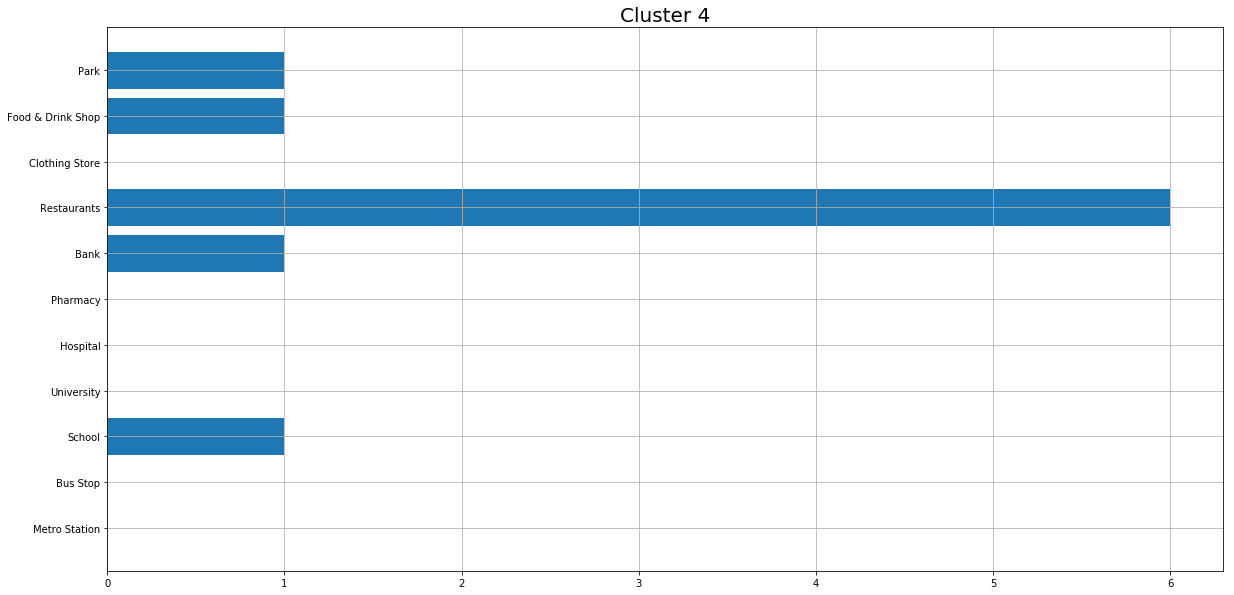

In [73]:
for cluster in range(0,kclusters):
    tmp=madrid_grouped_clustering[madrid_grouped_clustering['Cluster Labels']==cluster].mean(axis=0).round()
    tmp=pd.DataFrame(tmp).reset_index()
    plt.figure(figsize=(20,10))
    plt.barh(tmp.iloc[1:len(tmp)-2,0],tmp.iloc[1:len(tmp)-2,1])
    plt.title('Cluster '+str(int(tmp.iloc[0,1])),fontsize = 20)
    plt.grid()
    plt.show()

The analysis of the figures above shows that:
    - __Cluster 0__:  Has a reasonable number of metro and bus stations. There are several food, clothes stores, pharmacy, banks an restaurants. There is also a hospital and several schools. We therefore classified this cluster as __medium-high__
    - __Cluster 1__: In general terms this cluster has worse communications (metro and bus stops), no universities and less facilities (shops, restaurants, arts & entertainment) than cluster 0. Compared to cluster 2, this group is also less equipped. Therefore, it is classified as __medium-low__
    - __Cluster 2__: In terms of facilities, this cluster is between cluster 0 and cluster 1. Therefore, it is considered as __medium__
    - __Cluster 3__: This is the cluster with more clothes, restaurants, banks, pharmacies, schools, etc., therefore it classified as __high__
    - __Cluster 4__: Neighboorhoods in this group have poor or non communications, few facilities, no hospitals... so it is considered as __low__

Rename 'Clustet Labels' column based on the classification above

In [74]:
madrid_grouped_clustering['Cluster Labels']=madrid_grouped_clustering['Cluster Labels'].replace({0:'4: medium-high'})
madrid_grouped_clustering['Cluster Labels']=madrid_grouped_clustering['Cluster Labels'].replace({1:'2: medium-low'})
madrid_grouped_clustering['Cluster Labels']=madrid_grouped_clustering['Cluster Labels'].replace({2:'3: medium'})
madrid_grouped_clustering['Cluster Labels']=madrid_grouped_clustering['Cluster Labels'].replace({3:'5: high'})
madrid_grouped_clustering['Cluster Labels']=madrid_grouped_clustering['Cluster Labels'].replace({4:'1: low'})

In [75]:
madrid_grouped_clustering['latitude']=mad_neigh['latitude']
madrid_grouped_clustering['longitude']=mad_neigh['longitude']
madrid_grouped_clustering.head()

,Cluster Labels,Neighborhood,Metro Station,Bus Stop,School,University,Hospital,Pharmacy,Bank,Restaurants,Clothing Store,Food & Drink Shop,Park,Arts & Entertainment,Athletics & Sports,latitude,longitude
0,5: high,Palacio,3.0,3.0,9.0,3.0,0.0,22.0,23.0,50.0,48.0,48.0,7.0,50.0,18.0,40.4177,-3.71114
1,5: high,Embajadores,5.0,2.0,12.0,1.0,0.0,20.0,26.0,50.0,46.0,48.0,3.0,50.0,26.0,40.4105,-3.69986
2,5: high,Cortes,6.0,8.0,9.0,1.0,0.0,20.0,49.0,50.0,50.0,48.0,1.0,50.0,34.0,40.4165,-3.69657
3,5: high,Justicia,9.0,3.0,11.0,7.0,0.0,30.0,47.0,50.0,50.0,48.0,7.0,50.0,45.0,40.4245,-3.69748
4,5: high,Universidad,8.0,5.0,21.0,7.0,1.0,43.0,45.0,50.0,50.0,47.0,6.0,50.0,49.0,40.4268,-3.70497


Compute the center coordinates of the map as the mean latitudes and longitudes in the madrid_grouped_clustering dataframe

In [76]:
latitude=madrid_grouped_clustering['latitude'].mean()
longitude=madrid_grouped_clustering['longitude'].mean()

Display a folium map with the different clustes identified in the previous steps

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_grouped_clustering['latitude'], madrid_grouped_clustering['longitude'], madrid_grouped_clustering['Neighborhood'], madrid_grouped_clustering['Cluster Labels']):
    clusterNumber=int(cluster.split(':', 1)[0])-1
    label = folium.Popup(str(poi) + '\n' + cluster, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clusterNumber],
        fill=True,
        fill_color=rainbow[clusterNumber],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Sale and Rent Price Analysis

Sale price per square meter in the different districts and Neighborhoods of Madrid is obtained from https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/Areas-de-informacion-estadistica/Edificacion-y-vivienda/Mercado-de-la-vivienda/Precios-de-la-vivienda/?vgnextfmt=default&vgnextoid=bf281b47a277b210VgnVCM1000000b205a0aRCRD&vgnextchannel=22613c7ea422a210VgnVCM1000000b205a0aRCRD

Rent price per month and per square meter in the different districts of Madrid is obtained as well from the same site. However, note that the rent price is not available per neighborhood and therefore, it will be assumed the same rent price for all the neighborhoods within each district.

It is also important to consider that:
- Not all the neigborhoods in the madrid.json (used to get the list of neighborhoods) in Madrid are available in the sale price excel file. There are a couple of them missing that will be filled with zeros
- There are some discrepancies in the names used by both lists. For instance, there is no consistency in the use of accents. For that reason, before merging both lists, we will remove the accents. Then, we will add them again since we need to plot the map (neighborhoods names should be aligned with the names on the json)


#### Create Sales Price Data Frame

We get the sale prices from the "SalePrice.xls" file already downloaded

In [78]:
df_sale=pd.read_excel('SalePrice.xls', index_col=0)
df_sale.dropna(inplace=True)

In [79]:
df_sale.reset_index(inplace=True)

We cleanup the excel file to get a list of areas aligned with our main dataframe

In [80]:
df_sale[['District ID','District']]=df_sale['Distrito'].str.split('.', expand=True)

In [81]:
df_sale = df_sale[['District ID','District',2018]]
# remove accents
df_sale['District'] = df_sale['District'].apply(remove_accents)
df_sale.rename(columns={2018: 'Sale Price'}, inplace=True)

In [82]:
df_sale['District ID']=df_sale['District ID'].str.lstrip()
# Remove text in brackets
df_sale['District']=df_sale['District'].str.split('(', expand=True)[0]
df_sale['District']=df_sale['District'].str.strip()
# Remove duplicated rows
df_sale.drop_duplicates(subset='District', keep='first',inplace=True)

In [83]:
cols = ['District ID','District','Neighborhood','Sale Price']    
df_prices = pd.DataFrame(columns=cols)
for dID,name,sale_price in zip(df_sale['District ID'],df_sale['District'],df_sale['Sale Price']):
    
    if (len(dID)==2):
        # This is a district
        district=name
        districtPrice=sale_price
    else:
        # This is a neighborhood    
        if (sale_price ==".."):
            # Use the district price for the neighborhood
            sale_price=districtPrice
        
        df_prices = df_prices.append({'District ID':dID,
                        'District':unidecode.unidecode(district), # remove accents from district column
                        'Neighborhood':unidecode.unidecode(name), # remove accents from Neighborhood column
                        'Sale Price':sale_price}, ignore_index=True)

In [84]:
df_prices.head()

,District ID,District,Neighborhood,Sale Price
0,011,Centro,Palacio,4873
1,012,Centro,Embajadores,4239
2,013,Centro,Cortes,5106
3,014,Centro,Justicia,5989
4,015,Centro,Universidad,5068


#### Create Rent Prices DF

Repeat the same process for the rent prices

In [85]:
df_rent=pd.read_excel('RentPrice.xls', index_col=0)
# Get First Column only
df_rent=df_rent.iloc[:,0:1] 
# Drop NAN values
df_rent.dropna(inplace=True)
# Drop first two rows
df_rent=df_rent.iloc[2:-1,:]
df_rent.reset_index(inplace=True)
# Split first column by "."
df_rent[['District ID','District']]=df_rent['index'].str.split('.', expand=True)
df_rent['District']=df_rent['District'].str.strip()
df_rent['District ID']=df_rent['District ID'].str.strip()
# remove accents
df_rent['District'] = df_rent['District'].apply(remove_accents)
# Rename 2018 column
df_rent.rename(columns={2018: 'Rent Price'}, inplace=True)
# Drop index column and sort the DF
df_rent=df_rent[['District','Rent Price']]

Add rent prices to df_prices dataframe (assuming the same rent price for all the neighborhoods within the district)

In [86]:
## Add Rent Prices to df_prices dataframe (assuming the same rent price for all the neighborhoods within the district)
cols = ['Neighborhood','Rent Price']    
df_tmp = pd.DataFrame(columns=cols)
for district, neighborhood in zip(df_prices['District'],df_prices['Neighborhood']):
    try:
        rentPrice=df_rent[df_rent['District']==district]['Rent Price'].values.astype(float)[0]
    except:
        rentPrice=0
    df_tmp = df_tmp.append({'Neighborhood':name,
                        'Rent Price':rentPrice}, ignore_index=True)
df_prices['Rent Price']=df_tmp['Rent Price']

Compute the renting profit as the ratio between the rent (multiplied by 12) and the sale price.

In [87]:
df_prices['Profit']=100*12*df_prices['Rent Price']/df_prices['Sale Price']

In [88]:
df_prices.head(20)

,District ID,District,Neighborhood,Sale Price,Rent Price,Profit
0,011,Centro,Palacio,4873,19.0,4.67884
1,012,Centro,Embajadores,4239,19.0,5.37863
2,013,Centro,Cortes,5106,19.0,4.46533
3,014,Centro,Justicia,5989,19.0,3.80698
4,015,Centro,Universidad,5068,19.0,4.49882
5,016,Centro,Sol,5263,19.0,4.33213
6,021,Arganzuela,Imperial,3896,15.1,4.65092
7,022,Arganzuela,Acacias,4046,15.1,4.4785
8,023,Arganzuela,Chopera,3727,15.1,4.86182
9,024,Arganzuela,Legazpi,4263,15.1,4.25053


As mentioned before, giving that the use of accents in both dataframes is not consistent, we remove them before merging and then, we add them again

In [89]:
# remove accents from Neighborhood column in madrid_grouped_clustering using the previously defined function
madrid_grouped_clustering['Neighborhood'] = madrid_grouped_clustering['Neighborhood'].apply(remove_accents)

In [90]:
# Add Rent and Sale Prices
madrid_grouped_clustering= pd.merge(madrid_grouped_clustering, df_prices, on='Neighborhood', how='left')
# Recover the previously removed accents
madrid_grouped_clustering['Neighborhood']=mad_neigh['Neighborhood']


In [91]:
madrid_grouped_clustering.head(5)

,Cluster Labels,Neighborhood,Metro Station,Bus Stop,School,University,Hospital,Pharmacy,Bank,Restaurants,...,Park,Arts & Entertainment,Athletics & Sports,latitude,longitude,District ID,District,Sale Price,Rent Price,Profit
0,5: high,Palacio,3.0,3.0,9.0,3.0,0.0,22.0,23.0,50.0,...,7.0,50.0,18.0,40.4177,-3.71114,011,Centro,4873,19.0,4.67884
1,5: high,Embajadores,5.0,2.0,12.0,1.0,0.0,20.0,26.0,50.0,...,3.0,50.0,26.0,40.4105,-3.69986,012,Centro,4239,19.0,5.37863
2,5: high,Cortes,6.0,8.0,9.0,1.0,0.0,20.0,49.0,50.0,...,1.0,50.0,34.0,40.4165,-3.69657,013,Centro,5106,19.0,4.46533
3,5: high,Justicia,9.0,3.0,11.0,7.0,0.0,30.0,47.0,50.0,...,7.0,50.0,45.0,40.4245,-3.69748,014,Centro,5989,19.0,3.80698
4,5: high,Universidad,8.0,5.0,21.0,7.0,1.0,43.0,45.0,50.0,...,6.0,50.0,49.0,40.4268,-3.70497,015,Centro,5068,19.0,4.49882


Generate a summary df with the only required columns

In [92]:
madrid_summary_df=madrid_grouped_clustering[['Neighborhood','Cluster Labels','District', 'Sale Price', 'Rent Price', 'Profit']]
madrid_summary_df.head()

,Neighborhood,Cluster Labels,District,Sale Price,Rent Price,Profit
0,Palacio,5: high,Centro,4873,19.0,4.67884
1,Embajadores,5: high,Centro,4239,19.0,5.37863
2,Cortes,5: high,Centro,5106,19.0,4.46533
3,Justicia,5: high,Centro,5989,19.0,3.80698
4,Universidad,5: high,Centro,5068,19.0,4.49882


Display in Map the neighborhoods based on their potential renting profit

In [93]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
bins = list(madrid_summary_df['Profit'].quantile([0, 0.25, 0.5, 0.75,0.9,0.95,0.99, 1]))

folium.Choropleth(
        geo_data=madrid_json,
        name='choropleth',
        data=madrid_summary_df,
        columns=['Neighborhood', 'Profit'],
        key_on='properties.name',
        fill_color='Accent',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Cluster',
        bins=bins
        ).add_to(map_clusters)
       
folium.LayerControl().add_to(map_clusters)
map_clusters


If we look for the areas with more than a 10% profit we can see that there is only one neighborhood meeting this requirement.

However, although the profit of this area is high, the cluster classification shows that this is an area with very low facilities. 

Taking this into account, although the potential profit is high, this area is not recommended for buying.

## Discussion

In [94]:
madrid_summary_df[madrid_summary_df['Profit'] > 10]

,Neighborhood,Cluster Labels,District,Sale Price,Rent Price,Profit
107,San Cristobal,1: low,Villaverde,1252,10.8,10.3514


Therefore, instead of looking to the highest profit area, we are going to search for the best areas in terms of facilities (cluser label "5: high") and then identify the most profitable neighborhood

In [99]:
madrid_summary_df[madrid_summary_df['Cluster Labels'] == '4: medium-high'].sort_values(by='Profit',ascending=False).head(5)

,Neighborhood,Cluster Labels,District,Sale Price,Rent Price,Profit
31,Bellas Vistas,4: medium-high,Tetuan,3354,14.8,5.29517
93,Quintana,4: medium-high,Ciudad Lineal,2933,12.9,5.27787
21,Fuente del Berro,4: medium-high,Salamanca,4275,18.6,5.22105
8,Chopera,4: medium-high,Arganzuela,3727,15.1,4.86182
13,Pacífico,4: medium-high,Retiro,4059,16.2,4.78936


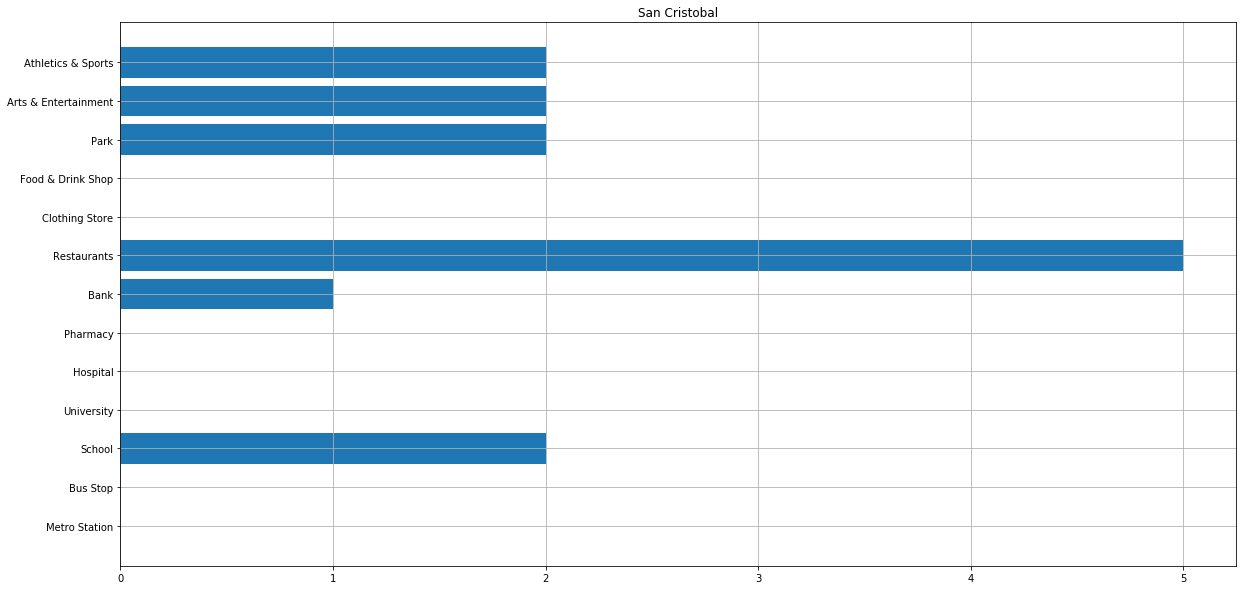

In [98]:
cristobal_df=madrid_grouped_clustering[madrid_grouped_clustering['Neighborhood']=='San Cristobal']
cristobal_df=cristobal_df.T.reset_index()

plt.figure(figsize=(20,10))
plt.barh(cristobal_df.iloc[2:len(cristobal_df)-7,0],cristobal_df.iloc[2:len(cristobal_df)-7,1])
plt.title('San Cristobal')
plt.grid()
plt.show()

## Conclusion

Taking into account the data and graphics provided along this report, the recommended neighborhood to buy a new house in Madrid is __Embajadores__

The features of this neighborhood are depicted in the following graphic:

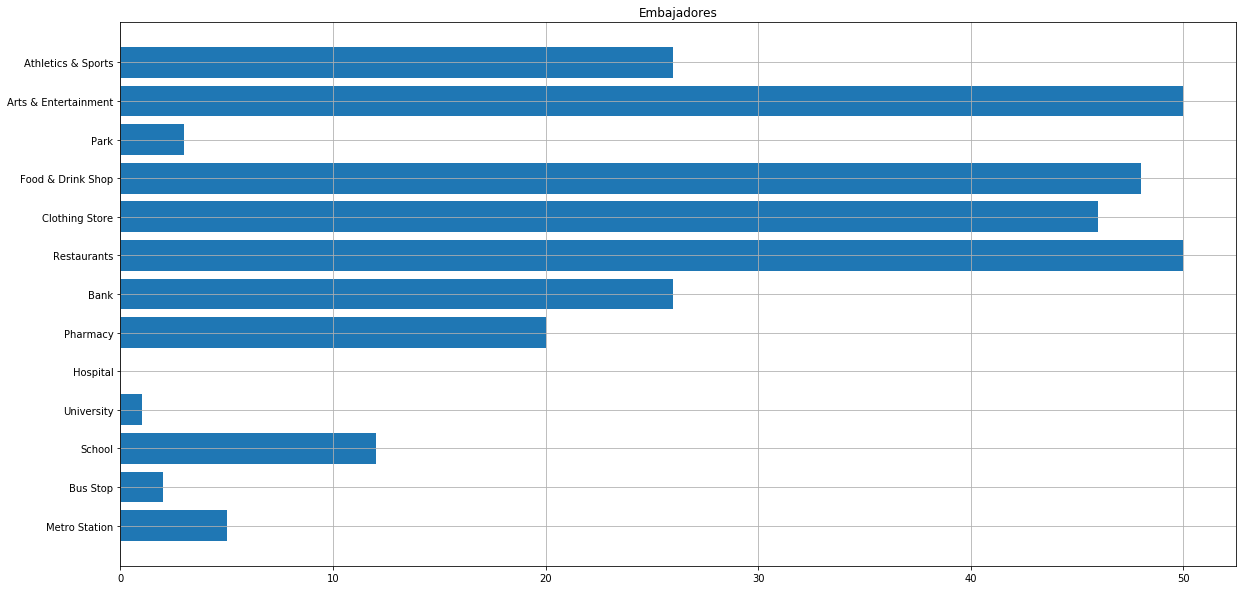

In [277]:
embajadores_df=madrid_grouped_clustering[madrid_grouped_clustering['Neighborhood']=='Embajadores']
embajadores_df=embajadores_df.T.reset_index()

plt.figure(figsize=(20,10))
plt.barh(embajadores_df.iloc[2:len(embajadores_df)-7,0],embajadores_df.iloc[2:len(embajadores_df)-7,1])
plt.title('Embajadores')
plt.grid()
plt.show()